In [1]:
## Experiment performed by:
## Arham Jain 23/CS/073

# Markov Decision Process

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Defining the Grid

In [3]:
# None = wall, 0 = normal cell, +1 = goal, -1 = pit
grid = np.array([
    [0,    0,    0,   +1],
    [0,  None,   0,   -1],
    [0,    0,    0,    0]
], dtype=object)

rows, cols = grid.shape

# Define actions
actions = ["up", "down", "left", "right"]

# Extract valid states from grid
states = [(i, j) for i in range(rows) for j in range(cols) if grid[i, j] is not None]

def R(state):
    value = grid[state]
    if value == 0:
        return -0.04   # living reward
    return value       # terminal states (±1)

def get_next_states(state, action):
    if state not in states:
        return []

    directions = {
        "up": (-1, 0),
        "down": (1, 0),
        "left": (0, -1),
        "right": (0, 1)
    }

    # Define perpendicular actions for stochastic movement
    left_turn = {"up": "left", "down": "right", "left": "down", "right": "up"}
    right_turn = {v: k for k, v in left_turn.items()}

    next_states = []
    x, y = state

    for a, prob in [
        (action, 0.8),
        (left_turn[action], 0.1),
        (right_turn[action], 0.1)
    ]:
        dx, dy = directions[a]
        nx, ny = x + dx, y + dy

        # Stay in place if hitting a wall or boundary
        if not (0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] is not None):
            nx, ny = x, y

        next_states.append((prob, (nx, ny)))

    return next_states


## Value Iteration

In [4]:
def value_iteration(gamma=0.99, theta=0.0001, max_iter=None):
    V_list = []
    deltas = []
    V = {s: 0.0 for s in states}
    V[(0, 3)] = R((0, 3))
    V[(1, 3)] = R((1, 3))
    i = 0
    V_list.append(V)

    while True:
        delta = 0
        V_next = V.copy()

        for s in states:
            if s in [(0, 3), (1, 3)]:
                continue

            action_values = []
            for a in actions:
                v = 0
                for prob, s_next in get_next_states(s, a):
                    reward = R(s)
                    v += prob * (reward + gamma * V[s_next])
                action_values.append(v)

            V_next[s] = max(action_values)
            delta = max(delta, abs(V[s] - V_next[s]))

        V = V_next
        i += 1
        if max_iter is not None and  i > max_iter:
            break

        V_list.append(V.copy())
        deltas.append(delta)
        if delta < theta:
            print(f"Converged after {i} iterations.")
            break

    return V, V_list, deltas

## Policy Extraction

In [5]:
def extract_policy(V, gamma=0.99):
    Pi = {}

    for s in states:
        if s in [(0, 3), (1, 3)]:
            continue

        action_values = {}
        for a in actions:
            q = 0
            for prob, s_next in get_next_states(s, a):
                q += prob * (R(s) + gamma * V[s_next])
            action_values[a] = q

        Pi[s] = max(action_values, key=action_values.get)

    return Pi

## Visualization and Analysis

In [6]:
def visualize_value_function(V):
    grid = np.zeros((3, 4))
    for i in range(3):
        for j in range(4):
            if (i, j) == (1, 1):
                grid[i, j] = np.nan
            elif (i, j) in V:
                grid[i, j] = V[(i, j)]
            else:
                grid[i, j] = 0

    plt.figure(figsize=(6, 4))
    sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=1, linecolor='black')
    plt.title("Value Function (V)")
    # plt.gca().invert_yaxis()  # Make (0,0) top-left
    plt.show()

def visualize_policy(Pi):
    arrow_map = {"up": "↑", "down": "↓", "left": "←", "right": "→"}
    grid = np.empty((3, 4), dtype=object)

    for i in range(3):
        for j in range(4):
            if (i, j) == (1, 1):
                grid[i, j] = "W"
            elif (i, j) == (0, 3):
                grid[i, j] = "G"
            elif (i, j) == (1, 3):
                grid[i, j] = "P"
            elif (i, j) in Pi:
                grid[i, j] = arrow_map.get(Pi[(i, j)], "•")
            else:
                grid[i, j] = "•"

    print("\nPolicy Grid:")
    for row in grid:
        print(" ".join(row))

Converged after 23 iterations.
{(0, 0): 0.776185500011894, (0, 1): 0.8439351062947532, (0, 2): 0.9050959034546806, (0, 3): 1, (1, 0): 0.7166319382178801, (1, 2): 0.6413273644285401, (1, 3): -1, (2, 0): 0.650660981587635, (2, 1): 0.5926685142761534, (2, 2): 0.5600700567311224, (2, 3): 0.3380387489476644}


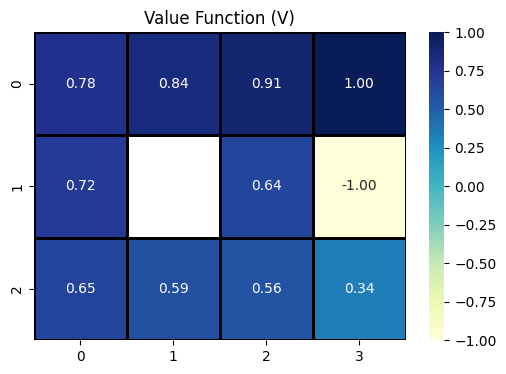


Policy Grid:
→ → → G
↑ W ↑ P
↑ ← ↑ ←


In [7]:
gamma = 0.99

V_final, _, deltas = value_iteration(gamma, theta=0.00001)
Pi_final = extract_policy(V_final, gamma)

print(V_final)
visualize_value_function(V_final)
visualize_policy(Pi_final)

# for v in _:
#     visualize_value_function(v)

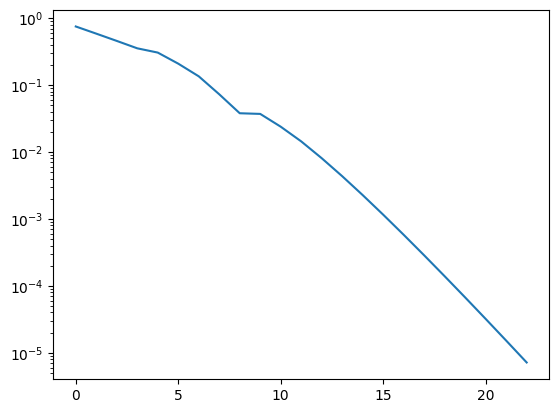

In [8]:
plt.plot(deltas)
plt.yscale('log')